# Clustering + Shape Fitting Exploratory Notebook

In [1]:
# Step 0: Setup
import numpy as np
from clustering_utils import *
from shape_fitting_utils import *

## Example Random Data

In [36]:
import numpy as np

np.random.seed(1)  # For reproducibility

n = 22  # Total number of points in the point cloud

# Points for the sphere
num_points_sphere = n // 2  # Half of the points
phi = np.random.uniform(0, np.pi, num_points_sphere)
theta = np.random.uniform(0, 2 * np.pi, num_points_sphere)
r_sphere = 3  # Radius of the sphere

X_sphere = r_sphere * np.sin(phi) * np.cos(theta) + 8  # Shifted along x-axis
Y_sphere = r_sphere * np.sin(phi) * np.sin(theta) + 8  # Shifted along y-axis
Z_sphere = r_sphere * np.cos(phi) + 8                  # Shifted along z-axis

# Points for the cylinder
num_points_cylinder = n - num_points_sphere  # Remaining points
theta_cyl = np.random.uniform(0, 2 * np.pi, num_points_cylinder)
z_cyl = np.random.uniform(8, 14, num_points_cylinder)  # Cylinder height from z=8 to z=14
r_cyl = 1.5  # Radius of the cylinder

X_cylinder = r_cyl * np.cos(theta_cyl) + 8
Y_cylinder = r_cyl * np.sin(theta_cyl) + 8
Z_cylinder = z_cyl

# Combine sphere and cylinder points
X = np.concatenate((X_sphere, X_cylinder))
Y = np.concatenate((Y_sphere, Y_cylinder))
Z = np.concatenate((Z_sphere, Z_cylinder))

point_cloud = np.vstack((X, Y, Z)).T


### Noising

In [37]:
# Step 2: Noise Addition and Reduction
noise_scale = 0.2
noise = np.random.normal(0, noise_scale, point_cloud.shape)
point_cloud_noisy = point_cloud + noise

### De-Noising

Original point cloud size: 22
Filtered point cloud size: 19


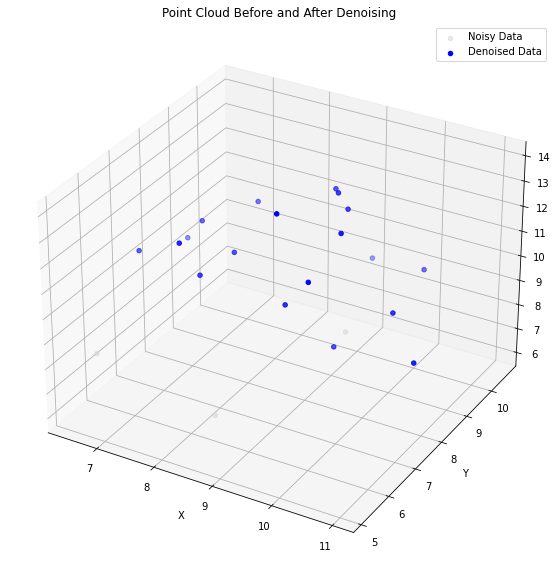

In [38]:
point_cloud_noisy = point_cloud_noisy

# Apply noise reduction
point_cloud_filtered = apply_noise_reduction(point_cloud_noisy, nb_neighbors=20, std_ratio=1.0)

print(f"Original point cloud size: {point_cloud_noisy.shape[0]}")
print(f"Filtered point cloud size: {point_cloud_filtered.shape[0]}")

# Visualize the results
visualize_denoising(point_cloud_noisy, point_cloud_filtered)

## Clustering

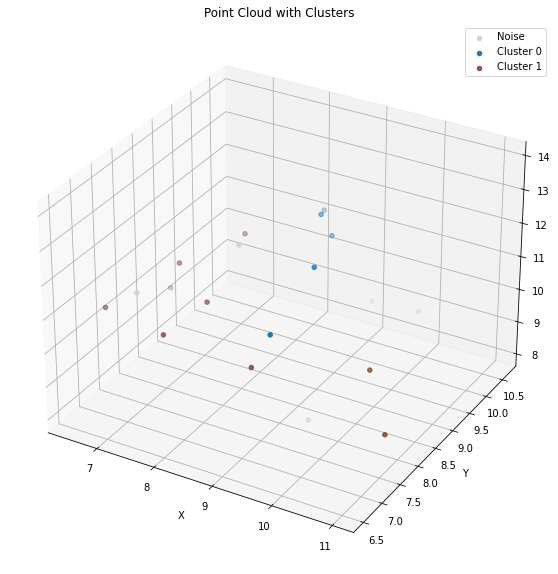

In [39]:

def plot_clusters(point_cloud, labels):
    """Function to plot the clusters in a 3D scatter plot."""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate a colormap
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab20', len(unique_labels))

    # Plot each cluster with a different color
    for label in unique_labels:
        if label == -1:  # Noise points
            color = 'lightgrey'
        else:
            color = colors(label)

        cluster_points = point_cloud[labels == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                   color=color, label=f'Cluster {label}' if label != -1 else 'Noise')

    ax.set_title('Point Cloud with Clusters')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Example usage in your notebook
algorithm = 'hdbscan'  # Choose from 'dbscan', 'hdbscan', 'meanshift', 'graph'
# kwargs = {'min_samples': 5, 'eps': 0.8}  # Pass relevant params for the clustering algorithm
kwargs = {'min_samples': 2}  # Pass relevant params for the clustering algorithm

labels = clustering_algorithm(algorithm, point_cloud_filtered, **kwargs)

# Plot the clusters
plot_clusters(point_cloud_filtered, labels)

## Shape Fitting

In [40]:
# Example thresholds (adjust)
thresholds = {
    'line': 1,
    'plane': 1,
    'sphere': 1,
    'cylinder': 1
}

cluster_models = {}

# Choose the method ('ransac_inlier', 'pca_ransac', 'pca_analysis', 'normal_estimation')
method = 'ransac_inlier'

for k in set(labels):
    if k == -1:
        continue  # Skip noise

    class_member_mask = (labels == k)
    cluster_data = point_cloud_filtered[class_member_mask]
    result = shape_fitting_algorithm(method, cluster_data, thresholds)

    # Store the result for visualization
    cluster_models[k] = result


## Final Visualization

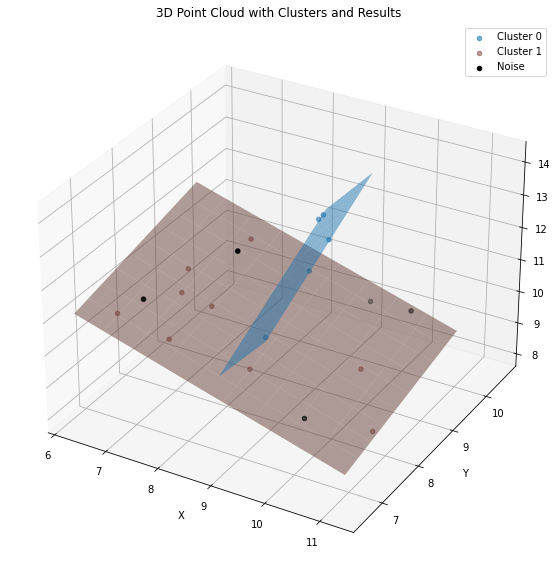

In [41]:
visualize_clusters_and_shapes(point_cloud_filtered, labels, cluster_models, method)